# Problem 1

**What is the difference between latency and throughput?**

- Latency is the time it takes for a single data record to move through the entire pipeline from ingestion to output. For example, in a pipeline that transforms raw customer data in JSON format, latency measures how long one JSON record takes to be fully processed end-to-end.
- Throughput is the volume of data the pipeline can process within a given time period. Using the same example, a pipeline with a throughput of 1,000 records per minute can successfully process 1,000 JSON records every minute.

**What is the role of Hadoop Distributed File System (HDFS) in a Big Data architecture?**

- Hadoop Distributed System (HDFS) is a storage system used by Hadoop applications. It works by splitting very large files into blocks and distributes them across many machines in a cluster, with each block replicated on multiple nodes. The presence of replicas makes HDFS fault tolerance as if a machine failed or even a rack of machines failed, we still have the replicas of the data available in other machines in other racks. In addition, the storage system is scalable as we can easily add in more machines or racks of machine.
- HDFS is optimized for high-throughput, batch reads and writes rather than low-latency random access, which makes it ideal for analytics workloads. Engines like MapReduce and Spark sit on top of HDFS, reading and processing data in parallel across the cluster, so HDFS effectively provides the shared data layer that all compute frameworks in the Hadoop ecosystem rely on.

**What are the key differences between ETL (Extract, Transform, Load) and ELT (Extract,**
**Load, Transform) in data processing? Provide examples of when you would use each.**

- ETL is Extract, Transform, Load where we extract data from source systems, transform it in a separate processing layer, and then load the cleaned, modelled data into the target system. The key idea is that the heavy transformation logic happens before the data reaches the warehouse, so the warehouse mainly stores curated, analytics ready tables. We typically use ETL when the target system is a traditional data warehouse with stricter schema and limited compute. An example of ETL is a company loading daily sales data into a traditional data warehouse. First, it extracts data from the cash register system and the product database at the end of each day. Then, on a separate ETL server, it transforms that data: cleans bad records, standardises dates and currencies, joins sales with product information, and calculates daily totals per store and product. Finally, it loads only the cleaned, aggregated tables into the warehouse, where analysts use them for reports and dashboards.
- ELT is Extract, Load, Transform where we extract from source systems, load the raw or lightly processed data directly into the target system, and perform transformations inside that system using its own compute engine. This is the pattern used with modern cloud data warehouses and data lakehouses such as Snowflake, BigQuery, and Databrick where storage is cheap and the warehouse itself is powerful enough to handle large-scale transformations. We use ELT when we would like to keep the raw data for future use, support multiple transformation versions, or let different teams build their own models on top of the same raw layer. An example of this is data from Kafka stream are stored as raw layer in Snowflake. The data is later processed and transformed into materialized tables to be analytic ready. 

**Compare RDBMS, Hadoop, and Spark in terms of data processing, scalability, and use cases.**

- Relational databases (RDBMS) is used for storing structured data with a fixed schema, strong ACID guarantees, and rich SQL support. They can be scaled vertically by having bigger single machine and horizontally by manual shading and partitioning, but overall scalability is limited. As data volumes grow, performance can degrade because queries depend on complex joins and heavy indexing over large tables. In addition, RDBMS also struggle with large scale real time streaming data. They also tend to be expensive (licenses, maintenance, powerful hardware), complex to tune on big tables, and rigid in schema changes.
- Hadoop (HDFS, MapReduce & ecosystem) provides distributed storage (HDFS) that scales horizontally to many commodity machines and can store huge volumes of structured, semi-structured, and unstructured data. It was designed to address the aforementioned weaknesses in RDBMS. MapReduce offers batch data processing across the cluster with high throughput, though latency is high because it is disk heavy and job oriented. Hadoop trades the strong schemas and low-latency queries of RDBMS for scalability, variety, and cost efficiency.
- Spark is a distributed computing engine that can run on top of Hadoop. Compared to Hadoop MapReduce, Spark keeps data in memory between steps, which makes it much faster for iterative algorithms and interactive analytics. It provides higher-level APIs for SQL, DataFrames, streaming, machine learning, and graph processing, so we can use one engine for many workloads. Spark also scales horizontally across clusters, like Hadoop, but with much better performance and flexibility. Typical use cases of Spark include large scale ETL, interactive analytics on big data, building machine learning models on distributed datasets, and streaming applications.

**Explain difference between structured, semi-structured and unstructured data.**

- Structured data is data with a fixed schema where each column has a predefined data type. The data can be displayed as tabular format. These data can be stored in traditional relation database. Examples of this data are customer names, dates of birth, phone numbers, and transactions.
- Semi-structured data is data without a fixed schema but they still contains elements such as labels or keys that make the data identifiable and searchable. Examples of this data are JSON and XML.
- Unstructured data is data without a fixed schema and they also do not have any tags or marker elements like semi-structure data. Examples of this data is text in documents or social media, customer feedback, images, audio, videos, and so on. With proper processing, we can extract useful information from them and turn them into structured data.

# Problem 2

In [1]:
import asyncio
import httpx
import matplotlib.pyplot as plt
import pandas as pd
from concurrent.futures import ThreadPoolExecutor, as_completed
from pathlib import Path
from typing import Iterable

from pyspark.ml import Pipeline
from pyspark.ml.base import Model
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.feature import OneHotEncoder, StringIndexer, VectorAssembler
from pyspark.ml.regression import (
    GBTRegressor,
    LinearRegression,
    RandomForestRegressor,
)
from pyspark.sql import DataFrame, SparkSession
from pyspark.sql import functions as F
from pyspark.sql.types import (
    DoubleType,
    IntegerType,
    StringType,
    StructField,
    StructType,
    TimestampType,
)

In [2]:
Path("data").mkdir(parents=True, exist_ok=True)
Path("databases").mkdir(parents=True, exist_ok=True)

## Task 1: Data Download

### Download TLC parquet files

In [3]:
BASE = "https://d37ci6vzurychx.cloudfront.net/trip-data"

def _build_urls(types: Iterable[str], years: Iterable[int], months: Iterable[int]) -> list[str]:
    """
    Build list of TLC parquet file URLs.

    Args:
        types: Iterable of taxi types.
        years: Iterable of years.
        months: Iterable of months.
    
    Returns:
        List of constructed URLs.
    """
    return [f"{BASE}/{t}_tripdata_{y}-{m:02d}.parquet" for t in types for y in years for m in months]

async def _fetch_content_length(client: httpx.AsyncClient, url: str, timeout: float) -> int | None:
    """
    Fetch content length of a URL via HEAD request.

    Args:
        client: httpx.AsyncClient instance.
        url: URL to fetch.
        timeout: Request timeout in seconds.
    
    Returns:
        Content length in bytes, or None if unavailable.
    """
    try:
        r = await client.head(url, timeout=timeout, follow_redirects=True)
        if r.status_code == 200:
            v = r.headers.get("content-length")
            return int(v) if v and v.isdigit() else None
        if r.status_code == 404:
            return None
        r.raise_for_status()
    except (httpx.HTTPError, httpx.TimeoutException):
        return None
    return None

def _build_dest_path(url: str, out_dir: Path) -> Path:
    """
    Determine destination path for a given URL.

    Args:
        url: URL of the file.
        out_dir: Base output directory.
        flat: Whether to store files in a flat structure.
    
    Returns:
        Path object representing the destination file path.
    """
    name = url.rsplit("/", 1)[-1]
    taxi_type = name.split("_", 1)[0]
    return out_dir / taxi_type / "parquet" / name

async def _download_one(
    client: httpx.AsyncClient,
    url: str,
    dest: Path,
    *,
    retries: int,
    timeout: float,
    sem: asyncio.Semaphore
) -> tuple[str, str]:
    """
    Download a single file with retries and resume support.
    
    Args:
        client: httpx.AsyncClient instance.
        url: URL to download.
        dest: Destination file path.
        retries: Number of retry attempts.
        timeout: Request timeout in seconds.
        sem: Semaphore for concurrency control.
    
    Returns:
        Tuple of URL and status string.
    """
    dest.parent.mkdir(parents=True, exist_ok=True)
    tmp = dest.with_suffix(dest.suffix + ".part")
    async with sem:
        remote_size = await _fetch_content_length(client, url, timeout)
        if dest.exists() and (remote_size is None or dest.stat().st_size == remote_size):
            return url, "skipped"
        attempt = 0
        backoff = 1.0
        while True:
            attempt += 1
            try:
                async with client.stream("GET", url, timeout=timeout, follow_redirects=True) as r:
                    if r.status_code == 404:
                        return url, "missing"
                    r.raise_for_status()
                    with tmp.open("wb") as f:
                        async for chunk in r.aiter_bytes():
                            f.write(chunk)
                if remote_size is not None and tmp.stat().st_size != remote_size:
                    raise IOError("size-mismatch")
                tmp.replace(dest)
                return url, "downloaded"
            except (httpx.TimeoutException, httpx.TransportError, httpx.HTTPStatusError, IOError):
                if attempt > retries:
                    try:
                        if tmp.exists():
                            tmp.unlink(missing_ok=True)
                    finally:
                        return url, "failed"
                await asyncio.sleep(backoff)
                backoff = min(backoff * 2, 30.0)

async def download_tlc_parquet(
    output_dir: str | Path = "data/tlc",
    types: Iterable[str] = ("yellow", "green"),
    years: Iterable[int] = range(2020, 2025),
    months: Iterable[int] = range(1, 13),
    *,
    concurrency: int = 5,
    retries: int = 3,
    timeout: float = 60.0,
) -> dict[str, int]:
    """
    Download NYC TLC parquet files once, with concurrency, retries, and resume.
    
    Args:
        output_dir: Directory to save downloaded files.
        types: Iterable of taxi types.
        years: Iterable of years.
        months: Iterable of months.
        concurrency: Number of concurrent downloads.
        retries: Number of retry attempts per file.
        timeout: Request timeout in seconds.
    
    Returns:
        Dictionary with download statistics.
    """
    out_dir = Path(output_dir)
    urls = _build_urls(types, years, months)
    sem = asyncio.Semaphore(concurrency)
    stats: dict[str, int] = {"downloaded": 0, "skipped": 0, "missing": 0, "failed": 0}
    async with httpx.AsyncClient(http2=True, headers={"Accept": "*/*"}) as client:
        tasks = [
            _download_one(
                client=client,
                url=url,
                dest=_build_dest_path(url, out_dir),
                retries=retries,
                timeout=timeout,
                sem=sem,
            )
            for url in urls
        ]
        for coroutine in asyncio.as_completed(tasks):
            _, status = await coroutine
            stats[status] = stats.get(status, 0) + 1
    return stats

In [4]:
stats = await download_tlc_parquet(output_dir="data/tlc", concurrency=5)
stats

{'downloaded': 120, 'skipped': 0, 'missing': 0, 'failed': 0}

### Convert parquet files to CSV

In [ ]:
def convert_parquets_to_csvs(
    base_dir: Path,
    taxis: Iterable[str] = ("yellow", "green"),
    max_workers: int = 12,
) -> None:
    """Convert all Parquet files under each taxi dir to CSV in parallel.

    Args:
        base_dir: Root directory containing taxi subfolders (e.g. data/tlc).
        taxis: Iterable of taxi subdirectory names (e.g. ["yellow", "green"]).
        max_workers: Maximum number of parallel workers for conversion.
    """
    tasks: list[tuple[str, Path, Path]] = []

    for taxi in taxis:
        parquet_dir = base_dir / taxi / "parquet"
        csv_dir = base_dir / taxi / "csv"
        csv_dir.mkdir(parents=True, exist_ok=True)

        for path in parquet_dir.glob("*.parquet"):
            out_path = csv_dir / (path.stem + ".csv")
            tasks.append((taxi, path, out_path))

    def _convert_one(taxi_name: str, src: Path, dst: Path) -> Path:
        try:
            if dst.exists():
                return dst
            df = pd.read_parquet(src)
            df.to_csv(dst, index=False)
            return dst
        except Exception as exc:
            raise RuntimeError(f"Failed converting {taxi_name} file {src}: {exc}") from exc

    with ThreadPoolExecutor(max_workers=max_workers) as pool:
        futures = {
            pool.submit(_convert_one, taxi, src, dst): (taxi, src, dst)
            for taxi, src, dst in tasks
        }
        for fut in as_completed(futures):
            taxi, src, dst = futures[fut]
            try:
                fut.result()
            except Exception as exc:
                print(f"[ERROR] {taxi} {src} -> {dst}: {exc}")

In [6]:
convert_parquets_to_csvs(Path("data/tlc"))

## Task 2: Data Processing with PySpark

### Load all the csv files as PySpark DataFrame

In [7]:
def download_sqlite_jdbc_driver() -> Path:
    """Download the SQLite JDBC driver if not already present."""
    url = "https://github.com/xerial/sqlite-jdbc/releases/download/3.51.0.0/sqlite-jdbc-3.51.0.0.jar"

    dest_dir = Path.home() / "jars"
    dest_dir.mkdir(parents=True, exist_ok=True)

    driver_dest_path = dest_dir / "sqlite-jdbc-3.51.0.0.jar"

    if driver_dest_path.exists():
        print(f"JDBC driver already exists at {driver_dest_path}")
    else:
        with httpx.stream("GET", url, timeout=30.0, follow_redirects=True) as resp:
            resp.raise_for_status()
            with driver_dest_path.open("wb") as f:
                for chunk in resp.iter_bytes():
                    if chunk:
                        f.write(chunk)
    
    return driver_dest_path

In [8]:
driver_dest_path = download_sqlite_jdbc_driver()

JDBC driver already exists at /home/dino/jars/sqlite-jdbc-3.51.0.0.jar


In [9]:
def get_spark(app_name: str = "csv_loader") -> SparkSession:
    """
    Return or create a SparkSession with sensible defaults for CSV ingestion.
    
    Args:
        app_name: Name of the Spark application.
    
    Returns:
        SparkSession instance.
    """
    return (
        SparkSession.builder.appName(app_name)
        .config("spark.jars", str(driver_dest_path))
        .getOrCreate()
    )

def load_csvs(spark: SparkSession, paths: Iterable[str] | str, schema: StructType) -> DataFrame:
    """
    Load one or many CSV paths into a single DataFrame.

    Args:
        spark: Active SparkSession.
        paths: Path of the CSV file(s).

    Returns:
        Unified DataFrame over all CSV files found.
    """
    reader = (
        spark.read
        .schema(schema)
        .option("header", "true")
        .option("inferSchema", "false")
        .option("mode", "PERMISSIVE")
        .option("delimiter", ",")
        .option("quote", '"')
        .option("escape", "\\")
        .option("recursiveFileLookup", "true")
    )

    if isinstance(paths, (str, Path)):
        return reader.csv(str(paths))
    return reader.csv(list(paths))



In [10]:
GREEN_TRIP_SCHEMA = StructType(
    [
        StructField("VendorID", IntegerType(), True),
        StructField("lpep_pickup_datetime", TimestampType(), True),
        StructField("lpep_dropoff_datetime", TimestampType(), True),
        StructField("store_and_fwd_flag", StringType(), True),
        StructField("RatecodeID", DoubleType(), True),
        StructField("PULocationID", IntegerType(), True),
        StructField("DOLocationID", IntegerType(), True),
        StructField("passenger_count", DoubleType(), True),
        StructField("trip_distance", DoubleType(), True),
        StructField("fare_amount", DoubleType(), True),
        StructField("extra", DoubleType(), True),
        StructField("mta_tax", DoubleType(), True),
        StructField("tip_amount", DoubleType(), True),
        StructField("tolls_amount", DoubleType(), True),
        StructField("ehail_fee", StringType(), True),
        StructField("improvement_surcharge", DoubleType(), True),
        StructField("total_amount", DoubleType(), True),
        StructField("payment_type", DoubleType(), True),
        StructField("trip_type", DoubleType(), True),
        StructField("congestion_surcharge", DoubleType(), True),
    ]
)

YELLOW_TRIP_SCHEMA = StructType(
    [
        StructField("VendorID", IntegerType(), True),
        StructField("tpep_pickup_datetime", TimestampType(), True),
        StructField("tpep_dropoff_datetime", TimestampType(), True),
        StructField("passenger_count", DoubleType(), True),
        StructField("trip_distance", DoubleType(), True),
        StructField("RatecodeID", DoubleType(), True),
        StructField("store_and_fwd_flag", StringType(), True),
        StructField("PULocationID", IntegerType(), True),
        StructField("DOLocationID", IntegerType(), True),
        StructField("payment_type", IntegerType(), True),
        StructField("fare_amount", DoubleType(), True),
        StructField("extra", DoubleType(), True),
        StructField("mta_tax", DoubleType(), True),
        StructField("tip_amount", DoubleType(), True),
        StructField("tolls_amount", DoubleType(), True),
        StructField("improvement_surcharge", DoubleType(), True),
        StructField("total_amount", DoubleType(), True),
        StructField("congestion_surcharge", DoubleType(), True),
        StructField("airport_fee", DoubleType(), True),
    ]
)


In [11]:
spark = get_spark()
spark.sparkContext.setLogLevel("ERROR")

Using Spark's default log4j profile: org/apache/spark/log4j2-defaults.properties
25/11/17 03:20:07 WARN Utils: Your hostname, Goku, resolves to a loopback address: 127.0.1.1; using 10.255.255.254 instead (on interface lo)
25/11/17 03:20:07 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
25/11/17 03:20:07 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
Using Spark's default log4j profile: org/apache/spark/log4j2-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


In [12]:
green_df = load_csvs(spark, "data/tlc/green/csv/", GREEN_TRIP_SCHEMA)
yellow_df = load_csvs(spark, "data/tlc/yellow/csv/", YELLOW_TRIP_SCHEMA)

green_df.printSchema()
yellow_df.printSchema()

root
 |-- VendorID: integer (nullable = true)
 |-- lpep_pickup_datetime: timestamp (nullable = true)
 |-- lpep_dropoff_datetime: timestamp (nullable = true)
 |-- store_and_fwd_flag: string (nullable = true)
 |-- RatecodeID: double (nullable = true)
 |-- PULocationID: integer (nullable = true)
 |-- DOLocationID: integer (nullable = true)
 |-- passenger_count: double (nullable = true)
 |-- trip_distance: double (nullable = true)
 |-- fare_amount: double (nullable = true)
 |-- extra: double (nullable = true)
 |-- mta_tax: double (nullable = true)
 |-- tip_amount: double (nullable = true)
 |-- tolls_amount: double (nullable = true)
 |-- ehail_fee: string (nullable = true)
 |-- improvement_surcharge: double (nullable = true)
 |-- total_amount: double (nullable = true)
 |-- payment_type: double (nullable = true)
 |-- trip_type: double (nullable = true)
 |-- congestion_surcharge: double (nullable = true)

root
 |-- VendorID: integer (nullable = true)
 |-- tpep_pickup_datetime: timestamp (null

### Data cleaning

In [13]:
green_nulls = green_df.select([
    F.count(F.when(F.col(c).isNull(), 1)).alias(c)
    for c in green_df.columns
])
yellow_nulls = yellow_df.select([
    F.count(F.when(F.col(c).isNull(), 1)).alias(c)
    for c in yellow_df.columns
])

green_nulls.show(truncate=False)
yellow_nulls.show(truncate=False)

+--------+--------------------+---------------------+------------------+----------+------------+------------+---------------+-------------+-----------+-----+-------+----------+------------+---------+---------------------+------------+------------+---------+--------------------+
|VendorID|lpep_pickup_datetime|lpep_dropoff_datetime|store_and_fwd_flag|RatecodeID|PULocationID|DOLocationID|passenger_count|trip_distance|fare_amount|extra|mta_tax|tip_amount|tolls_amount|ehail_fee|improvement_surcharge|total_amount|payment_type|trip_type|congestion_surcharge|
+--------+--------------------+---------------------+------------------+----------+------------+------------+---------------+-------------+-----------+-----+-------+----------+------------+---------+---------------------+------------+------------+---------+--------------------+
|0       |0                   |0                    |1110931           |1110931   |0           |0           |1110931        |0            |0          |0    |0     

+--------+--------------------+---------------------+---------------+-------------+----------+------------------+------------+------------+------------+-----------+-----+-------+----------+------------+---------------------+------------+--------------------+-----------+
|VendorID|tpep_pickup_datetime|tpep_dropoff_datetime|passenger_count|trip_distance|RatecodeID|store_and_fwd_flag|PULocationID|DOLocationID|payment_type|fare_amount|extra|mta_tax|tip_amount|tolls_amount|improvement_surcharge|total_amount|congestion_surcharge|airport_fee|
+--------+--------------------+---------------------+---------------+-------------+----------+------------------+------------+------------+------------+-----------+-----+-------+----------+------------+---------------------+------------+--------------------+-----------+
|0       |0                   |0                    |9057553        |0            |9057553   |9057553           |0           |0           |0           |0          |0    |0      |0        

In [14]:
green_rows = green_df.count()
yellow_rows = yellow_df.count()

green_null_pct = green_df.select([
    (F.count(F.when(F.col(c).isNull(), 1)) / F.lit(green_rows)).alias(c)
    for c in green_df.columns
])

yellow_null_pct = yellow_df.select([
    (F.count(F.when(F.col(c).isNull(), 1)) / F.lit(yellow_rows)).alias(c)
    for c in yellow_df.columns
])

green_null_pct.show(truncate=False)
yellow_null_pct.show(truncate=False)

+--------+--------------------+---------------------+-------------------+-------------------+------------+------------+-------------------+-------------+-----------+-----+-------+----------+------------+---------+---------------------+------------+-------------------+-------------------+--------------------+
|VendorID|lpep_pickup_datetime|lpep_dropoff_datetime|store_and_fwd_flag |RatecodeID         |PULocationID|DOLocationID|passenger_count    |trip_distance|fare_amount|extra|mta_tax|tip_amount|tolls_amount|ehail_fee|improvement_surcharge|total_amount|payment_type       |trip_type          |congestion_surcharge|
+--------+--------------------+---------------------+-------------------+-------------------+------------+------------+-------------------+-------------+-----------+-----+-------+----------+------------+---------+---------------------+------------+-------------------+-------------------+--------------------+
|0.0     |0.0                 |0.0                  |0.218231367511679

+--------+--------------------+---------------------+--------------------+-------------+--------------------+--------------------+------------+------------+------------+-----------+-----+-------+----------+------------+---------------------+------------+--------------------+-------------------+
|VendorID|tpep_pickup_datetime|tpep_dropoff_datetime|passenger_count     |trip_distance|RatecodeID          |store_and_fwd_flag  |PULocationID|DOLocationID|payment_type|fare_amount|extra|mta_tax|tip_amount|tolls_amount|improvement_surcharge|total_amount|congestion_surcharge|airport_fee        |
+--------+--------------------+---------------------+--------------------+-------------+--------------------+--------------------+------------+------------+------------+-----------+-----+-------+----------+------------+---------------------+------------+--------------------+-------------------+
|0.0     |0.0                 |0.0                  |0.051849458058839545|0.0          |0.051849458058839545|0.0

In [15]:
def clean_taxi_trips(
    df: DataFrame,
    pickup_col: str,
    dropoff_col: str,
) -> DataFrame:
    """
    Clean taxi trips DataFrame by removing rows with nulls or invalid values.

    Args:
        df: Input DataFrame.
        pickup_col: Name of the pickup datetime column.
        dropoff_col: Name of the dropoff datetime column.
    
    Returns:
        Cleaned DataFrame.
    """
    duration_seconds = F.col(dropoff_col).cast("long") - F.col(pickup_col).cast("long")

    return (
        df
        .filter(F.col(pickup_col).isNotNull())
        .filter(F.col(dropoff_col).isNotNull())
        .filter(F.col("PULocationID").isNotNull())
        .filter(F.col("DOLocationID").isNotNull())
        .filter(F.col("fare_amount").isNotNull() & (F.col("fare_amount") > 0))
        .filter(F.col("trip_distance").isNotNull() & (F.col("trip_distance") > 0))
        .filter(F.col("payment_type").isNotNull())
        .filter(F.year(F.col(pickup_col)) >= 2020)
        .filter(F.year(F.col(dropoff_col)) >= 2020)
        .filter(F.year(F.col(pickup_col)) <= 2025)
        .filter(F.year(F.col(dropoff_col)) <= 2025)
        .filter(duration_seconds > 0)
        .filter(duration_seconds <= 600 * 60)
    )

In [16]:
cleaned_green_df = clean_taxi_trips(green_df, "lpep_pickup_datetime", "lpep_dropoff_datetime")
cleaned_yellow_df = clean_taxi_trips(yellow_df, "tpep_pickup_datetime", "tpep_dropoff_datetime")

**What challenges did you face during the data cleaning process, and how did you**
**overcome them? Were there any aspects of the data that you found particularly**
**difficult to work with (e.g., missing values, outliers, or inconsistent data)?**

- The schema from the attached files on wiseflow is out of date. This cause problems when loading the CSV files as PySpark DataFrame.
I have to go to the website to get the latest schema definitions for both green and yellow taxi trip data.
However, even the lastest data dictionary on nyc.gov is not accurate. I have to do one more manual check on the data to get the schema right.
- We have many hidden problems in the data that I discover when doing the analysis. I have to go back to update the clean data function to remove those dirty data.
- The data has a lot of outliers which will affect the machine learning models later. Also, there are many inconsistency such as trips with high duration but low fare amount. Those are difficult to clean properly as we do not have the knowledge if they are truly wrong data or the fare amounts are just low due to different reasons.

## Task 3: Save Data into SQLite Database

In [17]:
DB_PATH = "databases/taxi_trips.db"
JDBC_URL = f"jdbc:sqlite:{DB_PATH}"
SQLITE_DRIVER = "org.sqlite.JDBC"

In [18]:
def write_to_sqlite(df: DataFrame, table: str, overwrite: bool) -> None:
    """
    Write a Spark DataFrame to a SQLite table via JDBC.

    Args:
        df: DataFrame to write.
        table: Name of the target SQLite table.
        overwrite: Whether to overwrite the table if it exists.
    """
    if Path(DB_PATH).exists() and not overwrite:
        return
    (
        df.coalesce(1)
        .write
        .format("jdbc")
        .option("url", JDBC_URL)
        .option("dbtable", table)
        .option("driver", SQLITE_DRIVER)
        .mode("overwrite")
        .save()
    )

In [19]:
write_to_sqlite(cleaned_green_df, "green_trips", overwrite=True)
write_to_sqlite(cleaned_yellow_df, "yellow_trips", overwrite=True)

In [20]:
spark.read.format("jdbc").option("url", JDBC_URL).option("dbtable", "green_trips").option("driver", SQLITE_DRIVER).load().show(5)

+--------+--------------------+---------------------+------------------+----------+------------+------------+---------------+-------------+-----------+-----+-------+----------+------------+---------+---------------------+------------+------------+---------+--------------------+
|VendorID|lpep_pickup_datetime|lpep_dropoff_datetime|store_and_fwd_flag|RatecodeID|PULocationID|DOLocationID|passenger_count|trip_distance|fare_amount|extra|mta_tax|tip_amount|tolls_amount|ehail_fee|improvement_surcharge|total_amount|payment_type|trip_type|congestion_surcharge|
+--------+--------------------+---------------------+------------------+----------+------------+------------+---------------+-------------+-----------+-----+-------+----------+------------+---------+---------------------+------------+------------+---------+--------------------+
|       2| 2020-01-01 00:45:58|  2020-01-01 00:56:39|                 N|       5.0|          66|          65|            2.0|         1.28|       20.0|  0.0|    0.

## Task 4: Exploratory Data Analysis with PySpark

In [21]:
def load_table(spark: SparkSession, db_path: Path, table: str) -> DataFrame:
    """
    Load a SQLite table into a Spark DataFrame via JDBC.

    Args:
        spark: Active SparkSession.
        db_path: Path to the SQLite database file.
        table: Name of the SQLite table to load.
    """
    url = f"jdbc:sqlite:{db_path}"
    return (
        spark.read.format("jdbc")
        .option("url", url)
        .option("dbtable", table)
        .option("driver", "org.sqlite.JDBC")
        .load()
    )

In [22]:
green_df = load_table(spark, Path(DB_PATH), "green_trips")
yellow_df = load_table(spark, Path(DB_PATH), "yellow_trips")

## Top 10 pickup locations

In [23]:
green_df.createOrReplaceTempView("green_trips")
yellow_df.createOrReplaceTempView("yellow_trips")

print("Top 10 Pickup Locations for Green Taxi Trips:")
spark.sql(
"""
    SELECT
        PULocationID,
        COUNT(*) AS trip_count
    FROM green_trips
    GROUP BY PULocationID
    ORDER BY trip_count DESC
    LIMIT 10
"""
).show(truncate=False)

print("Top 10 Pickup Locations for Yellow Taxi Trips:")
spark.sql(
"""
    SELECT
        PULocationID,
        COUNT(*) AS trip_count
    FROM yellow_trips
    GROUP BY PULocationID
    ORDER BY trip_count DESC
    LIMIT 10
"""
).show(truncate=False)

Top 10 Pickup Locations for Green Taxi Trips:


+------------+----------+
|PULocationID|trip_count|
+------------+----------+
|74          |665500    |
|75          |482791    |
|41          |255925    |
|166         |195109    |
|95          |170573    |
|82          |145355    |
|42          |133974    |
|43          |126248    |
|244         |119380    |
|97          |117739    |
+------------+----------+

Top 10 Pickup Locations for Yellow Taxi Trips:


+------------+----------+
|PULocationID|trip_count|
+------------+----------+
|237         |8140398   |
|236         |7385339   |
|132         |7229925   |
|161         |7154483   |
|162         |5749948   |
|186         |5738197   |
|142         |5508455   |
|230         |5156899   |
|170         |5139743   |
|239         |4884200   |
+------------+----------+



## Distribution of trips across different times of the day

In [24]:
print("Number of Green Taxi Trips by Hour of Day:")
spark.sql(
"""
    SELECT 
        HOUR(lpep_pickup_datetime) AS hour,
        COUNT(*) AS trip_count
    FROM green_trips
    GROUP BY hour
    ORDER BY hour
"""
).show(24, truncate=False)

print("Number of Yellow Taxi Trips by Hour of Day:")
spark.sql(
"""
    SELECT 
        HOUR(tpep_pickup_datetime) AS hour,
        COUNT(*) AS trip_count
    FROM yellow_trips
    GROUP BY hour
    ORDER BY hour
"""
).show(24, truncate=False)


Number of Green Taxi Trips by Hour of Day:


+----+----------+
|hour|trip_count|
+----+----------+
|0   |70355     |
|1   |48046     |
|2   |32138     |
|3   |25040     |
|4   |20629     |
|5   |21687     |
|6   |58571     |
|7   |130368    |
|8   |176521    |
|9   |194383    |
|10  |198897    |
|11  |202836    |
|12  |206119    |
|13  |206875    |
|14  |237415    |
|15  |262630    |
|16  |275196    |
|17  |287368    |
|18  |284596    |
|19  |237763    |
|20  |182623    |
|21  |150516    |
|22  |124787    |
|23  |101228    |
+----+----------+

Number of Yellow Taxi Trips by Hour of Day:


+----+----------+
|hour|trip_count|
+----+----------+
|0   |4455255   |
|1   |2927285   |
|2   |1919265   |
|3   |1287997   |
|4   |916291    |
|5   |1071116   |
|6   |2632525   |
|7   |4975153   |
|8   |6784457   |
|9   |7484460   |
|10  |8117038   |
|11  |8798649   |
|12  |9568687   |
|13  |9850843   |
|14  |10562600  |
|15  |10820290  |
|16  |10676203  |
|17  |11556711  |
|18  |12027148  |
|19  |10669879  |
|20  |9260004   |
|21  |8991578   |
|22  |8244594   |
|23  |6472296   |
+----+----------+



## Average fare amount for different distance intervals

In [25]:
green_bins_sql = spark.sql(
"""
    SELECT
        CASE
            WHEN trip_distance < 1 THEN '0-1'
            WHEN trip_distance >= 1 AND trip_distance < 2 THEN '1-2'
            WHEN trip_distance >= 2 AND trip_distance < 5 THEN '2-5'
            WHEN trip_distance >= 5 AND trip_distance < 10 THEN '5-10'
            WHEN trip_distance >= 10 AND trip_distance < 20 THEN '10-20'
            ELSE '>20'
        END AS distance_bin,
        AVG(fare_amount) AS avg_fare,
        CASE
            WHEN trip_distance < 1 THEN 1
            WHEN trip_distance >= 1 AND trip_distance < 2 THEN 2
            WHEN trip_distance >= 2 AND trip_distance < 5 THEN 3
            WHEN trip_distance >= 5 AND trip_distance < 10 THEN 4
            WHEN trip_distance >= 10 AND trip_distance < 20 THEN 5
            ELSE 6
        END AS bin_order
    FROM green_trips
    WHERE trip_distance IS NOT NULL
      AND fare_amount IS NOT NULL
      AND trip_distance > 0
      AND fare_amount > 0
    GROUP BY distance_bin, bin_order
    ORDER BY bin_order
""")

print("Average Fare by Distance Bin for Green Taxi Trips:")
green_bins_sql.select("distance_bin", "avg_fare").show(truncate=False)

yellow_bins_sql = spark.sql(
"""
    SELECT
        CASE
            WHEN trip_distance < 1 THEN '0-1'
            WHEN trip_distance >= 1 AND trip_distance < 2 THEN '1-2'
            WHEN trip_distance >= 2 AND trip_distance < 5 THEN '2-5'
            WHEN trip_distance >= 5 AND trip_distance < 10 THEN '5-10'
            WHEN trip_distance >= 10 AND trip_distance < 20 THEN '10-20'
            ELSE '>20'
        END AS distance_bin,
        AVG(fare_amount) AS avg_fare,
        CASE
            WHEN trip_distance < 1 THEN 1
            WHEN trip_distance >= 1 AND trip_distance < 2 THEN 2
            WHEN trip_distance >= 2 AND trip_distance < 5 THEN 3
            WHEN trip_distance >= 5 AND trip_distance < 10 THEN 4
            WHEN trip_distance >= 10 AND trip_distance < 20 THEN 5
            ELSE 6
        END AS bin_order
    FROM yellow_trips
    WHERE trip_distance IS NOT NULL
      AND fare_amount IS NOT NULL
      AND trip_distance > 0
      AND fare_amount > 0
    GROUP BY distance_bin, bin_order
    ORDER BY bin_order
"""
)

print("Average Fare by Distance Bin for Yellow Taxi Trips:")
yellow_bins_sql.select("distance_bin", "avg_fare").show(truncate=False)


Average Fare by Distance Bin for Green Taxi Trips:


+------------+------------------+
|distance_bin|avg_fare          |
+------------+------------------+
|0-1         |6.670290557579381 |
|1-2         |9.175778066911736 |
|2-5         |15.527945538090414|
|5-10        |28.100629382247817|
|10-20       |50.768502859292475|
|>20         |86.9295554145235  |
+------------+------------------+

Average Fare by Distance Bin for Yellow Taxi Trips:


+------------+------------------+
|distance_bin|avg_fare          |
+------------+------------------+
|0-1         |6.935461601542609 |
|1-2         |9.98067580920336  |
|2-5         |16.208299837446674|
|5-10        |29.45387777050977 |
|10-20       |53.533014386707734|
|>20         |78.02677739039788 |
+------------+------------------+



## Number of trips through time

In [26]:
green_trend_sql = spark.sql(
"""
    SELECT
        CAST(YEAR(lpep_pickup_datetime) AS INT) AS year,
        CAST(MONTH(lpep_pickup_datetime) AS INT) AS month,
        COUNT(*) AS trip_count
    FROM green_trips
    GROUP BY year, month
    ORDER BY year, month
"""
)

print("Number of Green Taxi Trips by Month and Year:")
green_trend_sql.show(100, truncate=False)

yellow_trend_sql = spark.sql(
"""
    SELECT
        CAST(YEAR(tpep_pickup_datetime) AS INT) AS year,
        CAST(MONTH(tpep_pickup_datetime) AS INT) AS month,
        COUNT(*) AS trip_count
    FROM yellow_trips
    GROUP BY year, month
    ORDER BY year, month
"""
)

print("Number of Yellow Taxi Trips by Month and Year:")
yellow_trend_sql.show(100, truncate=False)

Number of Green Taxi Trips by Month and Year:


+----+-----+----------+
|year|month|trip_count|
+----+-----+----------+
|2020|1    |313569    |
|2020|2    |302292    |
|2020|3    |167159    |
|2020|4    |22752     |
|2020|5    |28950     |
|2020|6    |35378     |
|2020|7    |39254     |
|2020|8    |42780     |
|2020|9    |45137     |
|2020|10   |48830     |
|2020|11   |45433     |
|2020|12   |43852     |
|2021|1    |38181     |
|2021|2    |33695     |
|2021|3    |40836     |
|2021|4    |42324     |
|2021|5    |46601     |
|2021|6    |50780     |
|2021|7    |47846     |
|2021|8    |47478     |
|2021|9    |57498     |
|2021|10   |69800     |
|2021|11   |70278     |
|2021|12   |70589     |
|2022|1    |52445     |
|2022|2    |57954     |
|2022|3    |65744     |
|2022|4    |63088     |
|2022|5    |61674     |
|2022|6    |59344     |
|2022|7    |52833     |
|2022|8    |55189     |
|2022|9    |57350     |
|2022|10   |58165     |
|2022|11   |52655     |
|2022|12   |61311     |
|2023|1    |60378     |
|2023|2    |56937     |
|2023|3    |6390

+----+-----+----------+
|year|month|trip_count|
+----+-----+----------+
|2020|1    |6303224   |
|2020|2    |6207632   |
|2020|3    |2959649   |
|2020|4    |230231    |
|2020|5    |336251    |
|2020|6    |529072    |
|2020|7    |770742    |
|2020|8    |973153    |
|2020|9    |1306374   |
|2020|10   |1641207   |
|2020|11   |1474833   |
|2020|12   |1428869   |
|2021|1    |1335250   |
|2021|2    |1337518   |
|2021|3    |1882252   |
|2021|4    |2123733   |
|2021|5    |2456696   |
|2021|6    |2780841   |
|2021|7    |2765037   |
|2021|8    |2731255   |
|2021|9    |2889279   |
|2021|10   |3400529   |
|2021|11   |3416267   |
|2021|12   |3156183   |
|2022|1    |2418867   |
|2022|2    |2927986   |
|2022|3    |3562325   |
|2022|4    |3535129   |
|2022|5    |3517527   |
|2022|6    |3480015   |
|2022|7    |3104383   |
|2022|8    |3078948   |
|2022|9    |3109356   |
|2022|10   |3585485   |
|2022|11   |3165735   |
|2022|12   |3309097   |
|2023|1    |2995670   |
|2023|2    |2847704   |
|2023|3    |3324

## Top 5 dropoff locations with highest average fare

In [27]:
top5_green_dropoff_sql = spark.sql(
"""
    SELECT
        DOLocationID,
        AVG(fare_amount) AS avg_fare
    FROM green_trips
    GROUP BY DOLocationID
    ORDER BY avg_fare DESC
    LIMIT 5
"""
)

print("Top 5 Dropoff Locations by Average Fare for Green Taxi Trips:")
top5_green_dropoff_sql.show(truncate=False)

top5_yellow_dropoff_sql = spark.sql(
"""
    SELECT
        DOLocationID,
        AVG(fare_amount) AS avg_fare
    FROM yellow_trips
    GROUP BY DOLocationID
    ORDER BY avg_fare DESC
    LIMIT 5
"""
)

print("Top 5 Dropoff Locations by Average Fare for Yellow Taxi Trips:")
top5_yellow_dropoff_sql.show(truncate=False)

Top 5 Dropoff Locations by Average Fare for Green Taxi Trips:


+------------+------------------+
|DOLocationID|avg_fare          |
+------------+------------------+
|204         |102.43636363636364|
|1           |97.02138974675731 |
|23          |77.68185121107265 |
|176         |75.81875          |
|5           |74.83383084577113 |
+------------+------------------+

Top 5 Dropoff Locations by Average Fare for Yellow Taxi Trips:


+------------+-----------------+
|DOLocationID|avg_fare         |
+------------+-----------------+
|204         |98.19538650306757|
|84          |96.78947010869554|
|110         |93.02857142857142|
|44          |92.22116195230343|
|265         |90.58974584452157|
+------------+-----------------+



## Weekends vs weekdays trips count

In [28]:
green_weekday_vs_weekend_sql = spark.sql(
"""
    SELECT
        CASE
            WHEN dayofweek(lpep_pickup_datetime) IN (1, 7) THEN 'weekend'
            ELSE 'weekday'
        END AS day_type,
        COUNT(*) AS trip_count
    FROM green_trips
    GROUP BY day_type
"""
)

print("Green Taxi Trips: Weekday vs Weekend Trip Counts:")
green_weekday_vs_weekend_sql.show(truncate=False)

yellow_weekday_vs_weekend = spark.sql(
"""
    SELECT
        CASE
            WHEN dayofweek(tpep_pickup_datetime) IN (1, 7) THEN 'weekend'
            ELSE 'weekday'
        END AS day_type,
        COUNT(*) AS trip_count
    FROM yellow_trips
    GROUP BY day_type
"""
)

print("Yellow Taxi Trips: Weekday vs Weekend Trip Counts:")
yellow_weekday_vs_weekend.show(truncate=False)

Green Taxi Trips: Weekday vs Weekend Trip Counts:


+--------+----------+
|day_type|trip_count|
+--------+----------+
|weekday |2807318   |
|weekend |929269    |
+--------+----------+

Yellow Taxi Trips: Weekday vs Weekend Trip Counts:


+--------+----------+
|day_type|trip_count|
+--------+----------+
|weekday |124769215 |
|weekend |45301109  |
+--------+----------+



## Average fare for trips with more than 10 miles distance

In [29]:
avg_fare_green_gt10_sql = spark.sql(
"""
    SELECT
        AVG(fare_amount) AS avg_fare_gt_10_miles
    FROM green_trips
    WHERE trip_distance > 10
"""
)

print("Average Fare for Green Taxi Trips Over 10 Miles:")
avg_fare_green_gt10_sql.show(truncate=False)

avg_fare_yellow_gt10_sql = spark.sql(
"""
    SELECT
        AVG(fare_amount) AS avg_fare_gt_10_miles
    FROM yellow_trips
    WHERE trip_distance > 10
"""
)

print("Average Fare for Yellow Taxi Trips Over 10 Miles:")
avg_fare_yellow_gt10_sql.show(truncate=False)


Average Fare for Green Taxi Trips Over 10 Miles:


+--------------------+
|avg_fare_gt_10_miles|
+--------------------+
|57.48850118048857   |
+--------------------+

Average Fare for Yellow Taxi Trips Over 10 Miles:


+--------------------+
|avg_fare_gt_10_miles|
+--------------------+
|56.77719817275841   |
+--------------------+



## Most Common Payment Type

In [30]:
print("Most Common Payment Type for Green Taxi Trips:")
spark.sql(
"""
    SELECT
        payment_type,
        COUNT(*) AS trip_count
    FROM green_trips
    GROUP BY payment_type
    ORDER BY trip_count DESC
    LIMIT 1
"""
).show(truncate=False)

print("Most Common Payment Type for Yellow Taxi Trips:")
spark.sql(
"""
    SELECT
        payment_type,
        COUNT(*) AS trip_count
    FROM yellow_trips
    GROUP BY payment_type
    ORDER BY trip_count DESC
    LIMIT 1
"""
).show(truncate=False)


Most Common Payment Type for Green Taxi Trips:


+------------+----------+
|payment_type|trip_count|
+------------+----------+
|1.0         |2299043   |
+------------+----------+

Most Common Payment Type for Yellow Taxi Trips:


+------------+----------+
|payment_type|trip_count|
+------------+----------+
|1           |128940211 |
+------------+----------+



**Reflect on the exploratory data analysis. What were the most interesting or unexpected**
**insights you discovered (e.g., busiest times, fare distribution, or trip distance trends)? How**
**did these insights influence the decisions you made for feature engineering or model**
**development?**

- Yellow taxis massively dominate volume compared to green, and both show clear peaks during the day. There is a sharp growth in the morning, with sustained peak from late morning to early evening. In addition, weekdays have more trips than weekends. This justify adding `pickup_hour`, `pickup_dow`, and `is_weekend` flag as time-based features.
- A small set of pick up zones account for a huge share of trips and some drop off zones have much higher average fares. This motivated keeping `PULocationID` and `DOLocationID` as categorical features.
- The average fare increases when distance bin increase, and trip over 10 miles for both fleets have very similar average fares. This confirm that `trip_distance` is the primary driver of fare and led to engineering both the raw `trip_distance` and a categorical `distance_bin` feature.

# Task 5: Feature Engineering

## 1. Extract Time Based Features

In [31]:
def add_time_features(df: DataFrame, pickup_col: str) -> DataFrame:
    """
    Add hour, day-of-week, weekend flag, and month based on the pickup timestamp.

    Args:
        df: Input DataFrame.
        pickup_col: Name of the pickup datetime column.

    Returns:
        DataFrame with added time features.
    """
    return (
        df
        .withColumn("pickup_hour", F.hour(F.col(pickup_col)))
        .withColumn("pickup_dow", F.dayofweek(F.col(pickup_col)))
        .withColumn(
            "is_weekend",
            F.when(F.col("pickup_dow").isin(1, 7), F.lit(1)).otherwise(F.lit(0))
        )
        .withColumn("pickup_month", F.month(F.col(pickup_col)))
    )

In [32]:
yellow_df = add_time_features(yellow_df, "tpep_pickup_datetime")
green_df  = add_time_features(green_df,  "lpep_pickup_datetime")

green_df.select(
    "lpep_pickup_datetime", "pickup_hour", "pickup_dow", "is_weekend", "pickup_month"
).show(5, truncate=False)
yellow_df.select(
    "tpep_pickup_datetime", "pickup_hour", "pickup_dow", "is_weekend", "pickup_month"
).show(5, truncate=False)

+--------------------+-----------+----------+----------+------------+
|lpep_pickup_datetime|pickup_hour|pickup_dow|is_weekend|pickup_month|
+--------------------+-----------+----------+----------+------------+
|2020-01-01 00:45:58 |0          |4         |0         |1           |
|2020-01-01 00:41:38 |0          |4         |0         |1           |
|2020-01-01 00:52:46 |0          |4         |0         |1           |
|2020-01-01 00:19:57 |0          |4         |0         |1           |
|2020-01-01 00:52:33 |0          |4         |0         |1           |
+--------------------+-----------+----------+----------+------------+
only showing top 5 rows
+--------------------+-----------+----------+----------+------------+
|tpep_pickup_datetime|pickup_hour|pickup_dow|is_weekend|pickup_month|
+--------------------+-----------+----------+----------+------------+
|2024-12-01 00:12:27 |0          |1         |1         |12          |
|2024-11-30 23:56:04 |23         |7         |1         |11        

## 2. Calculate Trip Duration

In [33]:
def add_trip_duration(
    df: DataFrame,
    pickup_col: str,
    dropoff_col: str,
) -> DataFrame:
    """
    Add trip duration in minutes based on pickup and dropoff timestamps.

    Args:
        df: Input DataFrame.
        pickup_col: Name of the pickup datetime column.
        dropoff_col: Name of the dropoff datetime column.
    
    Returns:
        DataFrame with added trip duration column.
    """
    return df.withColumn(
        "trip_duration_min",
        (F.col(dropoff_col).cast("long") - F.col(pickup_col).cast("long")) / 60.0,
    )

In [34]:
green_df  = add_trip_duration(green_df,  "lpep_pickup_datetime", "lpep_dropoff_datetime")
yellow_df = add_trip_duration(yellow_df, "tpep_pickup_datetime", "tpep_dropoff_datetime")

In [35]:
green_df.select(
    "lpep_pickup_datetime", "lpep_dropoff_datetime", "trip_duration_min"
).show(5, truncate=False)
yellow_df.select(
    "tpep_pickup_datetime", "tpep_dropoff_datetime", "trip_duration_min"
).show(5, truncate=False)

+--------------------+---------------------+------------------+
|lpep_pickup_datetime|lpep_dropoff_datetime|trip_duration_min |
+--------------------+---------------------+------------------+
|2020-01-01 00:45:58 |2020-01-01 00:56:39  |10.683333333333334|
|2020-01-01 00:41:38 |2020-01-01 00:52:49  |11.183333333333334|
|2020-01-01 00:52:46 |2020-01-01 01:14:21  |21.583333333333332|
|2020-01-01 00:19:57 |2020-01-01 00:30:56  |10.983333333333333|
|2020-01-01 00:52:33 |2020-01-01 01:09:54  |17.35             |
+--------------------+---------------------+------------------+
only showing top 5 rows
+--------------------+---------------------+-----------------+
|tpep_pickup_datetime|tpep_dropoff_datetime|trip_duration_min|
+--------------------+---------------------+-----------------+
|2024-12-01 00:12:27 |2024-12-01 00:31:12  |18.75            |
|2024-11-30 23:56:04 |2024-12-01 00:28:15  |32.18333333333333|
|2024-12-01 00:50:35 |2024-12-01 01:24:46  |34.18333333333333|
|2024-12-01 00:18:16 |

## 3. One-Hot Encoding for Categorical Features

In [36]:
def add_distance_bin(df: DataFrame) -> DataFrame:
    """
    Add a categorical distance_bin feature based on trip_distance.

    Args:
        df: Input DataFrame.
    
    Returns:
        DataFrame with added distance_bin column.
    """
    return (
        df
        .withColumn(
            "distance_bin",
            F.when(F.col("trip_distance") < 1, "0-1")
            .when((F.col("trip_distance") >= 1) & (F.col("trip_distance") < 2), "1-2")
            .when((F.col("trip_distance") >= 2) & (F.col("trip_distance") < 5), "2-5")
            .when((F.col("trip_distance") >= 5) & (F.col("trip_distance") < 10), "5-10")
            .when((F.col("trip_distance") >= 10) & (F.col("trip_distance") < 20), "10-20")
            .otherwise(">20")
        )
    )

In [37]:
green_df  = add_distance_bin(green_df)
yellow_df = add_distance_bin(yellow_df)

In [38]:
green_df.select(
    "distance_bin",
).show(5, truncate=False)
yellow_df.select(
    "distance_bin",
).show(5, truncate=False)

+------------+
|distance_bin|
+------------+
|1-2         |
|2-5         |
|5-10        |
|2-5         |
|2-5         |
+------------+
only showing top 5 rows
+------------+
|distance_bin|
+------------+
|5-10        |
|5-10        |
|>20         |
|2-5         |
|5-10        |
+------------+
only showing top 5 rows


In [39]:
def one_hot_encode_categoricals(df: DataFrame, categorical_cols: list[str]) -> DataFrame:
    """
    One-hot encode selected categorical columns.

    Args:
        df: Input DataFrame.
        categorical_cols: List of categorical column names to encode.
    
    Returns:
        DataFrame with one-hot encoded categorical features.
    """
    indexers: list[StringIndexer] = []
    encoders: list[OneHotEncoder] = []

    for col in categorical_cols:
        index_col = f"{col}_idx"
        ohe_col = f"{col}_ohe"

        indexers.append(
            StringIndexer(
                inputCol=col,
                outputCol=index_col,
                handleInvalid="keep",
            )
        )
        encoders.append(
            OneHotEncoder(
                inputCols=[index_col],
                outputCols=[ohe_col],
            )
        )

    pipeline = Pipeline(stages=[*indexers, *encoders])
    model = pipeline.fit(df)
    return model.transform(df)

In [40]:
green_df = one_hot_encode_categoricals(green_df, ["payment_type", "distance_bin"])
yellow_df = one_hot_encode_categoricals(yellow_df, ["payment_type", "distance_bin"])

In [41]:
green_df.select(
    "payment_type", "payment_type_idx", "payment_type_ohe",
    "distance_bin", "distance_bin_idx", "distance_bin_ohe",
).show(5, truncate=False)
yellow_df.select(
    "payment_type", "payment_type_idx", "payment_type_ohe",
    "distance_bin", "distance_bin_idx", "distance_bin_ohe",
).show(5, truncate=False)

+------------+----------------+----------------+------------+----------------+----------------+
|payment_type|payment_type_idx|payment_type_ohe|distance_bin|distance_bin_idx|distance_bin_ohe|
+------------+----------------+----------------+------------+----------------+----------------+
|1.0         |0.0             |(5,[0],[1.0])   |1-2         |1.0             |(6,[1],[1.0])   |
|1.0         |0.0             |(5,[0],[1.0])   |2-5         |0.0             |(6,[0],[1.0])   |
|2.0         |1.0             |(5,[1],[1.0])   |5-10        |3.0             |(6,[3],[1.0])   |
|1.0         |0.0             |(5,[0],[1.0])   |2-5         |0.0             |(6,[0],[1.0])   |
|1.0         |0.0             |(5,[0],[1.0])   |2-5         |0.0             |(6,[0],[1.0])   |
+------------+----------------+----------------+------------+----------------+----------------+
only showing top 5 rows
+------------+----------------+----------------+------------+----------------+----------------+
|payment_type|pa

**Which features did you find most important for predicting fare amounts, and why? If**
**you had more time or resources, are there additional features you would have liked**
**to include?**

- The most important features were the one that mirror how a taxi meter actually works. In this case, they are `trip_distance` and `distance_bin`. The fare increases as the trip distance increases. In addition, `trip_duration_min` is also an important feature to capture the time effect as the longer the trip, the higher the fare, especially in busy traffic hours where the trip duration tends to be higher.
- As the dataset is very large, and location and payment fields have hundreds of categories, fully one-hot encoding them would create a very high-dimensional sparse feature space and significantly slow down training given the computing power constraint. Thus, I chose to omit them from the training and testing data. If I have more time and resources, I would combine the trip data with the taxi zone lookup table from nyc.gov to use the zone for ML training.

# Task 6: Machine Learning with Spark ML

## 1. Prepare Data for Modeling

In [42]:
def vectorize_features(df: DataFrame) -> DataFrame:
    """
    Assemble numeric and one-hot-encoded features into a single vector column.
    
    Args:
        df: Input DataFrame.
    
    Returns:
        DataFrame with assembled feature vector column.
    """
    feature_cols = [
        "trip_distance",
        "trip_duration_min",
        "pickup_hour",
        "pickup_dow",
        "is_weekend",
        "pickup_month",
        "payment_type_ohe",
        "distance_bin_ohe",
    ]

    assembler = VectorAssembler(
        inputCols=feature_cols,
        outputCol="features",
        handleInvalid="skip",
    )

    return assembler.transform(df)

In [43]:
green_df = vectorize_features(green_df)
yellow_df = vectorize_features(yellow_df)

## 2. Train and Evaluate any three regression models

In [ ]:
def train_and_evaluate_models(
    df: DataFrame,
    label_col: str = "fare_amount",
) -> tuple[dict[str, Model], dict[str, dict[str, float]]]:
    """
    Train three regression models and return them with evaluation metrics.

    Args:
        df: Input DataFrame with 'features' and label_col.
        label_col: Name of the label column.

    Returns:
        A tuple of:
        - dict mapping model name -> trained Spark model
        - dict mapping model name -> dict of metrics {rmse, mae, r2}
    """
    train_df, test_df = df.select("features", label_col).randomSplit([0.8, 0.2], seed=42)

    estimators = {
        "LinearRegression": LinearRegression(
            featuresCol="features",
            labelCol=label_col,
            predictionCol="prediction",
            maxIter=50,
        ),
        "RandomForestRegressor": RandomForestRegressor(
            featuresCol="features",
            labelCol=label_col,
            predictionCol="prediction",
            numTrees=50,
            maxDepth=5,
        ),
        "GBTRegressor": GBTRegressor(
            featuresCol="features",
            labelCol=label_col,
            predictionCol="prediction",
            maxIter=20,
            maxDepth=5,
        ),
    }

    trained_models: dict[str, Model] = {}
    metrics: dict[str, dict[str, float]] = {}

    for name, estimator in estimators.items():
        print(f"\n=== {name} ===")
        model = estimator.fit(train_df)
        trained_models[name] = model

        preds = model.transform(test_df)

        model_metrics: dict[str, float] = {}
        for metric in ("rmse", "mae", "r2"):
            evaluator = RegressionEvaluator(
                labelCol=label_col,
                predictionCol="prediction",
                metricName=metric,
            )
            value = evaluator.evaluate(preds)
            model_metrics[metric] = value
            print(f"{metric.upper()}: {value:.4f}")

        metrics[name] = model_metrics

    return trained_models, metrics

In [45]:
green_trained_models, green_metrics = train_and_evaluate_models(green_df, label_col="fare_amount")
yellow_trained_models, yellow_metrics = train_and_evaluate_models(yellow_df, label_col="fare_amount")


=== LinearRegression ===


RMSE: 7.5781


MAE: 3.1054


R2: 0.7089

=== RandomForestRegressor ===


RMSE: 7.0526


MAE: 2.8456


R2: 0.7479

=== GBTRegressor ===


RMSE: 7.3741


MAE: 2.6531


R2: 0.7244

=== LinearRegression ===


RMSE: 56.2881


MAE: 3.1547


R2: 0.0568

=== RandomForestRegressor ===


RMSE: 56.2177


MAE: 3.1192


R2: 0.0591

=== GBTRegressor ===


RMSE: 56.2608


MAE: 2.8886


R2: 0.0577


In [46]:
print("\nGreen Taxi Models Metrics:")
for model_name, model_metrics in green_metrics.items():
    print(f"{model_name}: {model_metrics}")

print("\nYellow Taxi Models Metrics:")
for model_name, model_metrics in yellow_metrics.items():
    print(f"{model_name}: {model_metrics}")


Green Taxi Models Metrics:
LinearRegression: {'rmse': 7.578078595333142, 'mae': 3.105401877167837, 'r2': 0.7089160722857205}
RandomForestRegressor: {'rmse': 7.0525815436710495, 'mae': 2.8455609608149213, 'r2': 0.7478864147007311}
GBTRegressor: {'rmse': 7.374080485729156, 'mae': 2.6531228496804022, 'r2': 0.7243768048508226}

Yellow Taxi Models Metrics:
LinearRegression: {'rmse': 56.288096857422296, 'mae': 3.1546617806240334, 'r2': 0.05678902796927221}
RandomForestRegressor: {'rmse': 56.21770609685332, 'mae': 3.119177083309935, 'r2': 0.05914660719104603}
GBTRegressor: {'rmse': 56.26082225268298, 'mae': 2.888587725582627, 'r2': 0.05770287921459483}


## 3. Plot Actual vs Predicted Fare Amounts using Seaborn or Matplotlib

In [55]:
best_green_model = green_trained_models["RandomForestRegressor"]
best_yellow_model = yellow_trained_models["RandomForestRegressor"]

In [52]:
def plot_actual_vs_predicted(
    df: DataFrame, model: Model, taxi_name: str, model_name: str, fraction=0.05
) -> None:
    """
    Plot actual vs predicted fare amounts for a taxi model.

    Args:
        df: Input DataFrame.
        model: Trained Spark model.
        taxi_name: Name of the taxi type.
        model_name: Name of the model.
        fraction: Fraction of data to sample for plotting.
    """
    data = df.select("features", "fare_amount")
    _, test_df = data.randomSplit([0.8, 0.2], seed=42)

    preds = model.transform(test_df).select("fare_amount", "prediction")
    pdf = preds.sample(False, fraction, seed=42).toPandas()

    q_actual_low = pdf["fare_amount"].quantile(0.01)
    q_actual_high = pdf["fare_amount"].quantile(0.99)
    q_pred_low = pdf["prediction"].quantile(0.01)
    q_pred_high = pdf["prediction"].quantile(0.99)

    x_min, x_max = q_actual_low, q_actual_high
    y_min, y_max = q_pred_low, q_pred_high

    plt.style.use("seaborn-v0_8-whitegrid")

    fig, ax = plt.subplots(figsize=(7, 7))
    ax.scatter(
        pdf["fare_amount"],
        pdf["prediction"],
        s=10,
        alpha=0.25,
        edgecolors="none",
        color="#0d74bd",
    )

    line_min = min(x_min, y_min)
    line_max = max(x_max, y_max)
    ax.plot(
        [line_min, line_max],
        [line_min, line_max],
        linestyle="--",
        linewidth=1.2,
        color="#d56809",
    )

    ax.set_xlabel("Actual Fare Amount", fontsize=11)
    ax.set_ylabel("Predicted Fare Amount", fontsize=11)
    ax.set_title(
        f"Actual vs Predicted Fare for {taxi_name} Taxi Trips ({model_name})",
        fontsize=13,
    )

    ax.set_xlim(x_min, x_max)
    ax.set_ylim(y_min, y_max)
    ax.set_aspect("equal", adjustable="box")

    plt.tight_layout()
    plt.show()

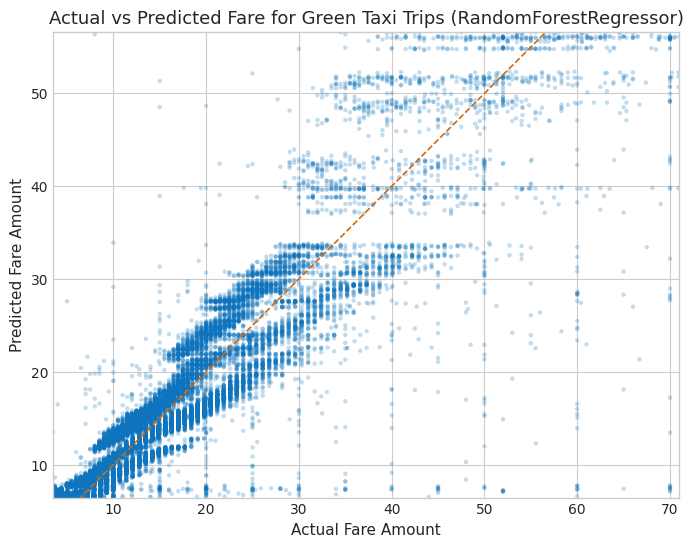

In [56]:
plot_actual_vs_predicted(
    df=green_df,
    model=best_green_model,
    taxi_name="Green",
    model_name="RandomForestRegressor"
)

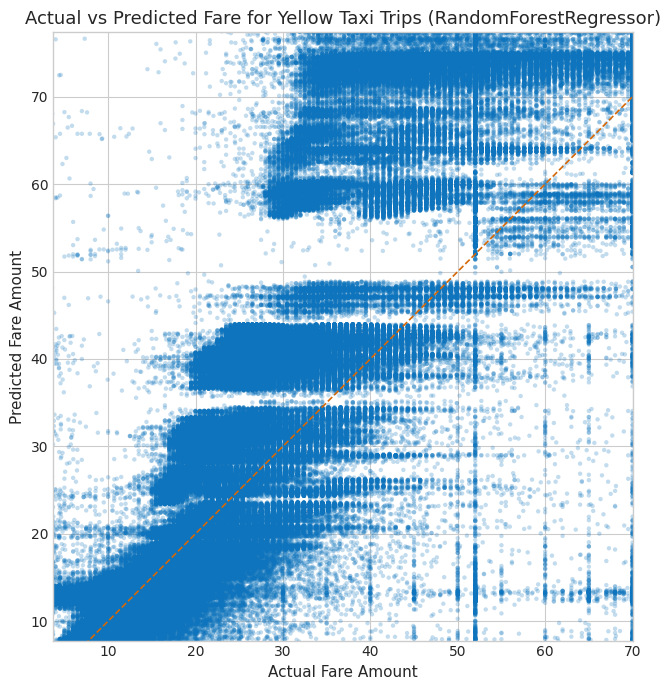

In [57]:
plot_actual_vs_predicted(
    df=yellow_df,
    model=best_green_model,
    taxi_name="Yellow",
    model_name="RandomForestRegressor"
)

## 4. Based on the performance metrics of your machine learning model (e.g., RMSE, R-
## squared), how well do you think your model predicts fare amounts? Were there
## any surprises in the model’s performance, and how would you improve the model
## if given more time?

- For green taxis, the RandomForestRegressor predicts fares reasonably well. The model is able to explain 75% of changes in `fare_amount`. In the plot, most points lie close to the diagonal for fares up to the 30 USD range, which means the model has good predictive power for typical trips. For trips above this range, the points spread out both above and below the line and form horizontal bands, indicating that the model still captures the general upward trend with fare but becomes less precise and more biased toward a few typical fare levels, especially for rarer, high-fare trips.
- For yellow taxis, the model is surprisingly a lot weaker than for green taxis. Even though the MAE is only ~3 USD, the R² is ≈ 0.06 and RMSE ≈ 56, which tells us the model explains almost none of the overall variance in `fare_amount`. From the plot, we can see that over predict in some fare ranges and under predict on other ranges. This suggest that, for yellow taxi, the current features are not enough to the explain much larger and more heterogeneous dataset.
- If I have more time, I would try to improve the data cleaning process to remove the outliers such as extreme fares, distances, and durations better. In addition, I would integrate the taxi zone data as mentioned to enrich the features. Finally, I would spend more time to fine tune the models and experiment with different parameters to understand the tradeoff of training time and model performance. This can help me to find a better approach to this problem or a more optimal way to build the ML pipeline.

## 5. What did you learn from this project that you didn’t know before? If you were to
## approach this project again, what would you do differently?

- From this project, I have learned how to build a  data pipeline with Python and Apache Spark,
from downloading and converting large TLC parquet files, to cleaning them,
engineering features, storing them in SQLite, and finally training and evaluating regression models. 
I got much more comfortable with Spark’s DataFrame API and SQL, especially for doing EDA at scale and 
understanding how choices like schema definition, filtering, and feature engineering directly affect model performance.
I also experienced how large dataset can introduce challenges on memory, run time, and model training.
- If I were to approach this project again, I would start with a smaller stratified sample to prototype and build the pipeline faster.
I would also improve the data cleaning process as mentioned due to outlier issues.
Finally, I would experiment with hyperparameter tuning and cross-validation to optimize model performance further.